<a href="https://colab.research.google.com/github/moey920/Object-Detection/blob/master/GloVe_%EC%8B%A4%EC%8A%B5(%ED%85%8D%EC%8A%A4%ED%8A%B8_%EC%A0%84%EC%B2%98%EB%A6%AC_%EC%A0%84)_02_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 글로브(GloVe)

글로브(Global Vectors for Word Representation, GloVe)는 카운트 기반과 예측 기반을 모두 사용하는 방법론으로 2014년에 미국 스탠포드대학에서 개발한 단어 임베딩 방법론입니다. 단정적으로 Word2Vec와 GloVe 중에서 어떤 것이 더 뛰어나다고 말할 수는 없고, 이 두 가지 전부를 사용해보고 성능이 더 좋은 것을 사용하는 것이 바람직합니다.

## 기존 방법론에 대한 비판
잠시 기존의 방법론을 복습해보겠습니다. LSA는 DTM이나 TF-IDF 행렬과 같이 각 문서에서의 각 단어의 빈도수를 카운트 한 행렬이라는 전체적인 통계 정보를 입력으로 받아 차원을 축소(Truncated SVD)하여 잠재된 의미를 끌어내는 방법론이었습니다. 반면, Word2Vec는 실제값과 예측값에 대한 오차를 손실 함수를 통해 줄여나가며 학습하는 예측 기반의 방법론이었습니다. 서로 다른 방법을 사용하는 이 두 방법론은 각각 장, 단점이 있습니다.
LSA는 카운트 기반으로 코퍼스의 전체적인 통계 정보를 고려하기는 하지만, 왕:남자 = 여왕:? (정답은 여자)와 같은 단어 의미의 유추 작업(Analogy task)에는 성능이 떨어집니다. Word2Vec는 예측 기반으로 단어 간 유추 작업에는 LSA보다 뛰어나지만, 임베딩 벡터가 윈도우 크기 내에서만 주변 단어를 고려하기 때문에 코퍼스의 전체적인 통계 정보를 반영하지 못합니다. GloVe는 이러한 기존 방법론들의 각각의 한계를 지적하며, LSA의 메커니즘이었던 카운트 기반의 방법과 Word2Vec의 메커니즘이었던 예측 기반의 방법론 두 가지를 모두 사용합니다.

## 도우 기반 동시 등장 행렬(Window based Co-occurrence Matrix)
단어의 동시 등장 행렬은 행과 열을 전체 단어 집합의 단어들로 구성하고, i 단어의 윈도우 크기(Window Size) 내에서 k 단어가 등장한 횟수를 i행 k열에 기재한 행렬을 말합니다. 예제를 보면 어렵지 않습니다. 아래와 같은 텍스트가 있다고 해봅시다.
Ex) I like deep learning I like NLP I enjoy flying
윈도우 크기가 N일 때는 좌, 우에 존재하는 N개의 단어만 참고하게 됩니다. 윈도우 크기가 1일 때, 위의 텍스트를 가지고 구성한 동시 등장 행렬은 다음과 같습니다.

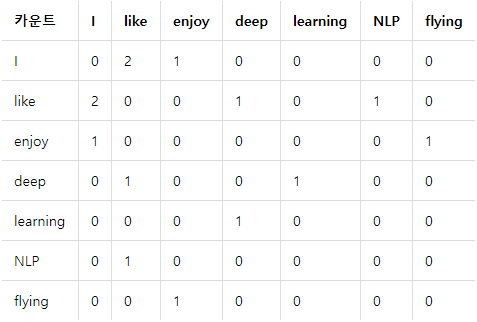

위 행렬은 행렬을 전치(Transpose)해도 동일한 행렬이 된다는 특징이 있습니다. 그 이유는 i 단어의 윈도우 크기 내에서 k 단어가 등장한 빈도는 반대로 k 단어의 윈도우 크기 내에서 i 단어가 등장한 빈도와 동일하기 때문입니다.

## 동시 등장 확률(Co-occurrence Probability)
이제 동시 등장 행렬에 대해서 이해했으니, 동시 등장 확률에 대해서 이해해봅시다. 아래의 표는 어떤 동시 등장 행렬을 가지고 정리한 동시 등장 확률(Co-occurrence Probability)을 보여줍니다. 그렇다면, 동시 등장 확률이란 무엇일까요?
동시 등장 확률 P(k | i)는 동시 등장 행렬로부터 특정 단어 i의 전체 등장 횟수를 카운트하고, 특정 단어 i가 등장했을 때 어떤 단어 k가 등장한 횟수를 카운트하여 계산한 조건부 확률입니다.
P(k | i)에서 i를 중심 단어(Center Word), k를 주변 단어(Context Word)라고 했을 때, 위에서 배운 동시 등장 행렬에서 중심 단어 i의 행의 모든 값을 더한 값을 분모로 하고 i행 k열의 값을 분자로 한 값이라고 볼 수 있겠습니다. 다음은 GloVe의 제안 논문에서 가져온 동시 등장 확률을 표로 정리한 하나의 예입니다.

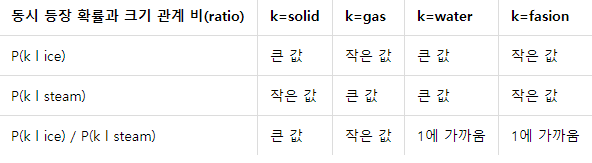

위의 표를 통해 알 수 있는 사실은 solid가 등장했을 때 ice가 등장할 확률 0.00019은 solid가 등장했을 때 steam이 등장할 확률인 0.000022보다 약 8.9배 크다는 겁니다. 그도 그럴 것이 solid는 '단단한'이라는 의미를 가졌으니까 '증기'라는 의미를 가지는 steam보다는 당연히 '얼음'이라는 의미를 가지는 ice라는 단어와 더 자주 등장할 겁니다.
수식적으로 다시 정리하여 언급하면 k가 solid일 때, P(solid l ice) / P(solid l steam)를 계산한 값은 8.9가 나옵니다. 이 값은 1보다는 매우 큰 값입니다. 왜냐면 P(solid | ice)의 값은 크고, P(solid | steam)의 값은 작기 때문입니다.
그런데 k를 solid가 아니라 gas로 바꾸면 얘기는 완전히 달라집니다. gas는 ice보다는 steam과 더 자주 등장하므로, P(gas l ice) / P(gas l steam)를 계산한 값은 1보다 훨씬 작은 값인 0.085가 나옵니다. 반면, k가 water인 경우에는 solid와 steam 두 단어 모두와 동시 등장하는 경우가 많으므로 1에 가까운 값이 나오고, k가 fasion인 경우에는 solid와 steam 두 단어 모두와 동시 등장하는 경우가 적으므로 1에 가까운 값이 나옵니다. 보기 쉽도록 조금 단순화해서 표현한 표는 다음과 같습니다.

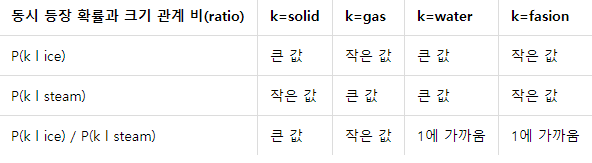

이제 동시 등장 행렬과 동시 등장 확률의 이해를 바탕으로 손실 함수를 설계해보겠습니다.

##손실 함수(Loss function)

우선 손실 함수를 설명하기 전에 각 용어를 정리해보겠습니다.
X : 동시 등장 행렬(Co-occurrence Matrix) Xij : 중심 단어 i가 등장했을 때 윈도우 내 주변 단어 j가 등장하는 횟수 Xi:∑jXij : 동시 등장 행렬에서 i행의 값을 모두 더한 값 Pik : P(k | i) = XikXi : 중심 단어 i가 등장했을 때 윈도우 내 주변 단어 k가 등장할 확률 Ex) P(solid l ice) = 단어 ice가 등장했을 때 단어 solid가 등장할 확률 PikPjk : Pik를 Pjk로 나눠준 값 Ex) P(solid l ice) / P(solid l steam) = 8.9 wi : 중심 단어 i의 임베딩 벡터 wk~ : 주변 단어 k의 임베딩 벡터 GloVe의 아이디어를 한 줄로 요약하면 '임베딩 된 중심 단어와 주변 단어 벡터의 내적이 전체 코퍼스에서의 동시 등장 확률이 되도록 만드는 것'입니다. 즉, 이를 만족하도록 임베딩 벡터를 만드는 것이 목표입니다. 이를 식으로 표현하면 다음과 같습니다.
dot product(wi wk~)≈ P(k | i)=Pikk
최종적으로 다음과 같은 일반화 된 손실 함수를 얻어낼 수 있습니다. 

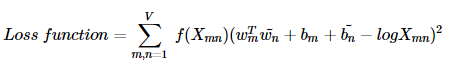

이제 GloVe 패키지를 설치 및 실습하고 훈련 결과를 확인해보겠습니다.

# 환경 설치 및 데이터 준비

In [11]:
!pip install glove_python
'''
glove_python은 그냥 glove 1.0.x 버전과 다르게 corpus를 포함하고 있습니다.
콘다 환경에서 pip install glove_python을 했을 때 C++ 빌더 등의 오류가 발생하여 설치되지 않는 경우가 많은 것 같습니다.
따라서 콘다 환경에 설치가 되는 사람은 그대로 진행하고, 안되면 구글 Colab을 이용해서 pip install glove_python을 하면 진행이 됩니다.
'''

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700328 sha256=54f557d09435a6dd816d76044a77017f0e9cc51d6e67a9fb934a79a2f173c274
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


'\nglove_python은 그냥 glove 1.0.x 버전과 다르게 corpus를 포함하고 있습니다.\n콘다 환경에서 pip install glove_python을 했을 때 C++ 빌더 등의 오류가 발생하여 설치되지 않는 경우가 많은 것 같습니다.\n따라서 콘다 환경에 설치가 되는 사람은 그대로 진행하고, 안되면 구글 Colab을 이용해서 pip install glove_python을 하면 진행이 됩니다.\n'

In [12]:
!pip install konlpy
# 콘다 환경에서 벗어났으니 필요한 라이브러리는 필요할 때마다 다운로드 해주겠습니다.

     |████████████████████████████████| 19.4MB 234kB/s 
     |████████████████████████████████| 2.3MB 52.6MB/s 
     |████████████████████████████████| 92kB 12.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [0]:
# Colab은 내 컴퓨터 디렉토리의 Path를 읽어올 수 없기 때문에 구글 드라이브 API를 활용하여 파일을 가져오도록 하겠습니다.
# Google Drive api 활용, PyDrive package 인스톨
!pip install -U -q PyDrive

In [0]:
# Auth 승인을 받습니다. 코드 실행 시 링크가 나오면 들어가서 계정을 인증하고 인증 코드를 복사해 붙여넣습니다.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
   
# PyDrive Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Folder Id로 FileList 받아오기
# 폴더 ID는 개인 드라이브에서 폴더에 들어가면 https://drive.google.com/drive/folders/ 이후에 나오는 주소입니다.

folder_id = '1e56SssWMsdvHBd550OJYeiDx3ghOlRir'
   
def ListFolder(parent):
    filelist=[]
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % parent}).GetList()
    for f in file_list:
        if f['mimeType']=='application/vnd.google-apps.folder': # if folder
            filelist.append({"id":f['id'],"title":f['title'],"list":ListFolder(f['id'])})
        else:
            filelist.append({"title":f['title'],"id":f['id']})
    return filelist
   
   
file_lists = ListFolder(folder_id)


In [0]:
# Local (colaboratory) directory 지정
# choose a local (colab) directory to store the data.
import os

local_download_path = os.path.expanduser('')
try:
	os.makedirs(local_download_path)
except: pass

In [6]:
# Filename 저장, 여기까지 하면 구글 드라이브 폴더 내의 파일을 Colab에 지정한 장소에 업로드 됩니다.
ret = []
for file in file_lists:
    print('title: %s, id: %s' % (file['title'], file['id']))
    fname = os.path.join(local_download_path, file['title'])
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': file['id']})
    f_.GetContentFile(fname)
    print(fname)
    ret.append(fname)

title: data.txt, id: 1RG8b1UbNjoJotDH_i6zX_JoEbshxhVFT
downloading to data.txt
data.txt


In [7]:
# 현재 위치에 data.txt가 잘 업로드 되어는지 확인합니다.
!ls

adc.json  data.txt  sample_data


# GloVe 실습

In [0]:
# result(훈련 데이터) 생성을 위해 가지고 있는 텍스트에서 토큰화를 진행합니다.
from konlpy.tag import Okt  
okt=Okt()
fread = open('data.txt', encoding="utf8")
# 파일을 다시 처음부터 읽음.
n=0
result = []

while True:
    line = fread.readline() #한 줄씩 읽음.
    if not line: break # 모두 읽으면 while문 종료.
    n=n+1
    if n%5000==0: # 5,000의 배수로 While문이 실행될 때마다 몇 번째 While문 실행인지 출력.
        print("%d번째 While문."%n)
    tokenlist = okt.pos(line, stem=True, norm=True) # 단어 토큰화
    temp=[]
    for word in tokenlist:
        if word[1] in ["Noun"]: # 명사일 때만
            temp.append((word[0])) # 해당 단어를 저장함

    if temp: # 만약 이번에 읽은 데이터에 명사가 존재할 경우에만
        result.append(temp) # 결과에 저장
fread.close()

In [14]:
from glove import Corpus, Glove

corpus = Corpus() 
corpus.fit(result, window=5)
# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성

glove = Glove(no_components=100, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
# 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.

Performing 20 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [15]:
# 학습이 완료되었습니다. glove.most_similar()는 입력 단어의 가장 유사한 단어들의 리스트를 리턴합니다.
model_result1=glove.most_similar("결제")
print(model_result1)

[('일로', 0.8768321451710981), ('단', 0.8670437968967123), ('불가', 0.8395591836248583), ('환불', 0.8392504893167456)]


In [16]:
model_result1=glove.most_similar("금액")
print(model_result1)

[('이상', 0.9370858793652012), ('해당', 0.9296973853255271), ('승인', 0.9036287688028547), ('수량', 0.8902161112902403)]


In [17]:
model_result1=glove.most_similar("수량")
print(model_result1)

[('단가', 0.9878728587009833), ('이상', 0.9528640790722894), ('해당', 0.8994669328766772), ('승인', 0.8961616834306816)]


In [19]:
model_result1=glove.most_similar("번호")
print(model_result1)

[('회원', 0.9732011653479031), ('시불', 0.9712213223703083), ('승인', 0.8949609745320855), ('신분', 0.851980496683197)]


예상대로 결제에 결제금액과 결제방법 등 중요한 레이블들을 유사성이 있다고 판단하지는 않았지만,
Word2Vec로 훈련한 결과보다는 훨씬 의미있는 단어들을 뽑아내는데 성공했습니다.
(구글 드라이브의 Word2Ved*.ipynb를 참고해주십시오)